In [57]:
## import
import treeple.tree._honest_tree
from treeple.ensemble._supervised_forest import ObliqueRandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from gpu_forest import GPUObliqueRandomForest
import os
import cupy as cp
from joblib import Parallel, delayed

In [3]:
## Feature normalization
df_human = pd.read_excel('data/Human.parcellated_thickness.xlsx')
df_human.head()

df_human_normalize= {}
features = df_human.columns[2:]  # features are from the 2nd column to the last

# Z-score normalization
for feature in features:
    mean = df_human[feature].mean()
    std = df_human[feature].std()
    df_human_normalize[feature] = (df_human[feature] - mean) / std

# Save the Human normalized data
df_human_normalize = pd.DataFrame(df_human_normalize)
label_human = df_human.iloc[:, :2]
df_human_normalize = pd.concat([label_human, df_human_normalize], axis=1)
df_human_normalize.to_excel('data/normalized/Human_normalized_parcellated_thickness.xlsx', index=False)

df_human_normalize_markov = df_human_normalize.loc[:, ~df_human_normalize.columns.str.startswith('Schaefer')]


In [4]:
df_sex = pd.read_excel('data/subjects_age_sex_data_MRI.xlsx')

## set up training data
X1 = []
X2 = []
y_human = []
IDs = set(df_human_normalize_markov['sid'])
ref_IDs = set(df_sex['ID'])

for subject in tqdm(IDs):
    if subject in ref_IDs:
        features = np.array(df_human_normalize_markov[df_human_normalize_markov['sid']==subject]).reshape(-1)[2:]
        gender = list(df_sex[df_sex['ID']==subject]['Sex'])
        sex = int(gender[0]=='FEMALE')

        X1.append(list(features[:182]))
        X2.append(list(features[182:]))
        y_human.append(sex)

X1_human = np.array(X1)
X2_human = np.array(X2)

100%|██████████| 14465/14465 [00:10<00:00, 1427.51it/s]


In [6]:
X1_human = np.nan_to_num(X1_human)
X2_human = np.nan_to_num(X2_human)
X_human = np.concatenate((X1_human,X2_human),axis=1)

# Test on SPORF

In [ ]:
### SPORF ###
reps = 5
sporf_accuracy = []
n_estimator = 2000
accuracies = []
for ii in tqdm(range(reps)):
    x_train, x_test, y_train, y_test = train_test_split(
                    X1_human, y_human, train_size=0.8, random_state=ii, stratify=y_human)
    clf = ObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, feature_combinations=3.47, max_features=0.993)
    clf.fit(x_train, y_train)
    accuracy = np.mean(clf.predict(x_test)==y_test)
    accuracies.append(accuracy)
sporf_accuracy = np.concatenate((sporf_accuracy, accuracies))
print('Accuracy for n_estimator = ', n_estimator,' is ', accuracies)

#sporf_accuracy = sporf_accuracy.reshape(5, 5)
print(sporf_accuracy)

100%|██████████| 5/5 [15:30<00:00, 186.06s/it]

Accuracy for n_estimator =  2000  is  [np.float64(0.7248826291079812), np.float64(0.7370892018779343), np.float64(0.7234741784037558), np.float64(0.7084507042253522), np.float64(0.7286384976525822)]


ValueError: cannot reshape array of size 5 into shape (5,5)

In [9]:
sporf_accuracy

array([0.72488263, 0.7370892 , 0.72347418, 0.7084507 , 0.7286385 ])

# Frame work to test trunk simulation on multiple supervised tree classifiers

In [56]:
# Import the supervised tree estimators from the treeple package.
# (Make sure treeple is installed and the estimators below exist in your version.)
import treeple.ensemble._supervised_forest
from treeple.ensemble._supervised_forest import (ObliqueRandomForestClassifier,
                     ExtraObliqueRandomForestClassifier, 
                     PatchObliqueRandomForestClassifier)

# --- Parameters ---
reps = 5  # number of repetitions for each configuration
n_estimator = 500  # parameter for ensemble classifiers
# List of noise dimensions to add (0 means no extra noise; higher values add more noise)
noise_dims_list = [0, 10, 20, 30, 40, 80, 120, 160, 200]

# Define a dictionary of estimator constructors.
# We wrap each estimator in a lambda so that a fresh instance is created for each run.
estimators = {
    "ObliqueRandomForest": lambda: ObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, feature_combinations=2.3),
    "ExtraObliqueRandomForest": lambda: ExtraObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1),
    "PatchObliqueRandomForestClassifier": lambda: PatchObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1)
}


In [ ]:
estimators = {
    "ObliqueRandomForest": lambda: ObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1, feature_combinations=2.3),
    "ExtraObliqueRandomForest": lambda: ExtraObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1),
    "PatchObliqueRandomForestClassifier": lambda: PatchObliqueRandomForestClassifier(n_estimators=n_estimator, n_jobs=-1)
}
# This dictionary will store results for each estimator and each noise level.
# The structure will be: results[estimator_name][noise_dim] = {"accuracy": avg_accuracy, "time": avg_train_time}
results = {est_name: {} for est_name in estimators.keys()}

# For each noise level, add that many extra columns (noise features) to your original data.
for noise_dim in noise_dims_list:
    print(f"\n=== Testing with {noise_dim} noisy dimensions added ===")
    
    # For each estimator from treeple
    for est_name, est_constructor in estimators.items():
        accuracies = []
        train_times = []
        
        # Repeat the experiment several times to average out randomness.
        for rep in tqdm(range(reps), desc=f"{est_name}, noise dims={noise_dim}"):
            # Create noise features: shape = (n_samples, noise_dim)
            if noise_dim > 0:
                noise_features = np.random.normal(0, 1, size=(X1_human.shape[0], noise_dim))
                X_sim = np.concatenate([X1_human, noise_features], axis=1)
            else:
                X_sim = X1_human.copy()
            
            # Split the data (80% training, 20% testing) with stratification
            X_train, X_test, y_train, y_test = train_test_split(
                X_sim, y_human, train_size=0.8, random_state=rep, stratify=y_human)
            
            # Initialize the classifier
            clf = est_constructor()
            
            # Record training time
            start_time = time.time()
            clf.fit(X_train, y_train)
            end_time = time.time()
            runtime = end_time - start_time
            
            # Compute accuracy on the test set
            y_pred = clf.predict(X_test)
            accuracy = np.mean(y_pred == y_test)
            
            accuracies.append(accuracy)
            train_times.append(runtime)
        
        # Save average results for this estimator and noise level.
        avg_accuracy = np.mean(accuracies)
        avg_time = np.mean(train_times)
        results[est_name][noise_dim] = {"accuracy": avg_accuracy, "time": avg_time}
        print(f"{est_name} | Noise dims: {noise_dim} | Avg. Accuracy: {avg_accuracy:.4f} | Avg. Training Time: {avg_time:.4f} sec")

# Optionally, print a summary of all results.
print("\n=== Summary of Results ===")
for est_name, noise_results in results.items():
    print(f"\nEstimator: {est_name}")
    for noise_dim, metrics in noise_results.items():
        print(f"  Noise dims: {noise_dim} | Accuracy: {metrics['accuracy']:.4f} | Training Time: {metrics['time']:.4f} sec")


Manually set n_jobs to -2 using joblib and save results to result/result.txt

In [58]:
# Dictionary to store results (results[estimator][noise_dim] = {"accuracy": avg_accuracy, "time": avg_train_time})
results = {est_name: {} for est_name in estimators.keys()}

# Define the simulation function for one run.
def run_simulation(estimator_constructor, noise_dim, rep, X_data, y_data):
    # Add noise dimensions if needed.
    if noise_dim > 0:
        noise_features = np.random.normal(0, 1, size=(X_data.shape[0], noise_dim))
        X_sim = np.concatenate([X_data, noise_features], axis=1)
    else:
        X_sim = X_data.copy()
    
    # Split the data (80% training, 20% testing) with stratification.
    X_train, X_test, y_train, y_test = train_test_split(
        X_sim, y_data, train_size=0.8, random_state=rep, stratify=y_data)
    
    clf = estimator_constructor()
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    accuracy = np.mean(clf.predict(X_test) == y_test)
    return accuracy, train_time

# For each noise level, run the simulation for each estimator.
for noise_dim in noise_dims_list:
    print(f"\n=== Testing with {noise_dim} noisy dimensions added ===")
    for est_name, est_constructor in estimators.items():
        # Run simulation reps in parallel.
        simulation_results = Parallel(n_jobs=-2)(
            delayed(run_simulation)(est_constructor, noise_dim, rep, X1_human, y_human) 
            for rep in range(reps)
        )
        # Unpack the results.
        accuracies, times = zip(*simulation_results)
        avg_accuracy = np.mean(accuracies)
        avg_time = np.mean(times)
        results[est_name][noise_dim] = {"accuracy": avg_accuracy, "time": avg_time}
        print(f"{est_name} | Noise dims: {noise_dim} | Avg. Accuracy: {avg_accuracy:.4f} | Avg. Training Time: {avg_time:.4f} sec")

# Optionally, print a summary of all results.
print("\n=== Summary of Results ===")
for est_name, noise_results in results.items():
    print(f"\nEstimator: {est_name}")
    for noise_dim, metrics in noise_results.items():
        print(f"  Noise dims: {noise_dim} | Accuracy: {metrics['accuracy']:.4f} | Training Time: {metrics['time']:.4f} sec")

# --- Save results to a text file ---
# We'll build an array with rows corresponding to noise dimensions and columns as:
# [noise_dim, ObliqueRandomForest_accuracy, ObliqueRandomForest_time, 
#         ExtraObliqueRandomForest_accuracy, ExtraObliqueRandomForest_time, 
#         PatchObliqueRandomForestClassifier_accuracy, PatchObliqueRandomForestClassifier_time]

num_noise = len(noise_dims_list)
num_classifiers = len(estimators)
# The first column is the noise dimension, then two columns per classifier.
output_array = np.zeros((num_noise, 1 + num_classifiers * 2))

# Fill in the noise dimensions.
output_array[:, 0] = noise_dims_list

# Fill in the results for each estimator.
for j, est_name in enumerate(estimators.keys()):
    for i, noise_dim in enumerate(noise_dims_list):
        output_array[i, 1 + 2*j]     = results[est_name][noise_dim]["accuracy"]
        output_array[i, 1 + 2*j + 1] = results[est_name][noise_dim]["time"]

# Prepare a header for the text file.
header_str = ("Noise_dim, "
              "ObliqueRandomForest_Accuracy, ObliqueRandomForest_Time, "
              "ExtraObliqueRandomForest_Accuracy, ExtraObliqueRandomForest_Time, "
              "PatchObliqueRandomForestClassifier_Accuracy, PatchObliqueRandomForestClassifier_Time")

# Save the array to a text file.
result_folder = "./result"
output_filepath = os.path.join(result_folder, "results.txt")
np.savetxt(output_filepath, output_array, header=header_str, delimiter=",", fmt="%.4f")

print(f"\nResults saved to {output_filepath}")


=== Testing with 0 noisy dimensions added ===
ObliqueRandomForest | Noise dims: 0 | Avg. Accuracy: 0.7084 | Avg. Training Time: 8.7234 sec
ExtraObliqueRandomForest | Noise dims: 0 | Avg. Accuracy: 0.6808 | Avg. Training Time: 3.9645 sec
PatchObliqueRandomForestClassifier | Noise dims: 0 | Avg. Accuracy: 0.6168 | Avg. Training Time: 22.9789 sec

=== Testing with 10 noisy dimensions added ===
ObliqueRandomForest | Noise dims: 10 | Avg. Accuracy: 0.7038 | Avg. Training Time: 8.9843 sec
ExtraObliqueRandomForest | Noise dims: 10 | Avg. Accuracy: 0.6763 | Avg. Training Time: 4.1599 sec
PatchObliqueRandomForestClassifier | Noise dims: 10 | Avg. Accuracy: 0.6103 | Avg. Training Time: 28.8863 sec

=== Testing with 20 noisy dimensions added ===
ObliqueRandomForest | Noise dims: 20 | Avg. Accuracy: 0.6992 | Avg. Training Time: 10.0807 sec
ExtraObliqueRandomForest | Noise dims: 20 | Avg. Accuracy: 0.6736 | Avg. Training Time: 3.8708 sec
PatchObliqueRandomForestClassifier | Noise dims: 20 | Avg. A

plot the accuracy decrease & training time increase percentage against percentage of noisy feature increase

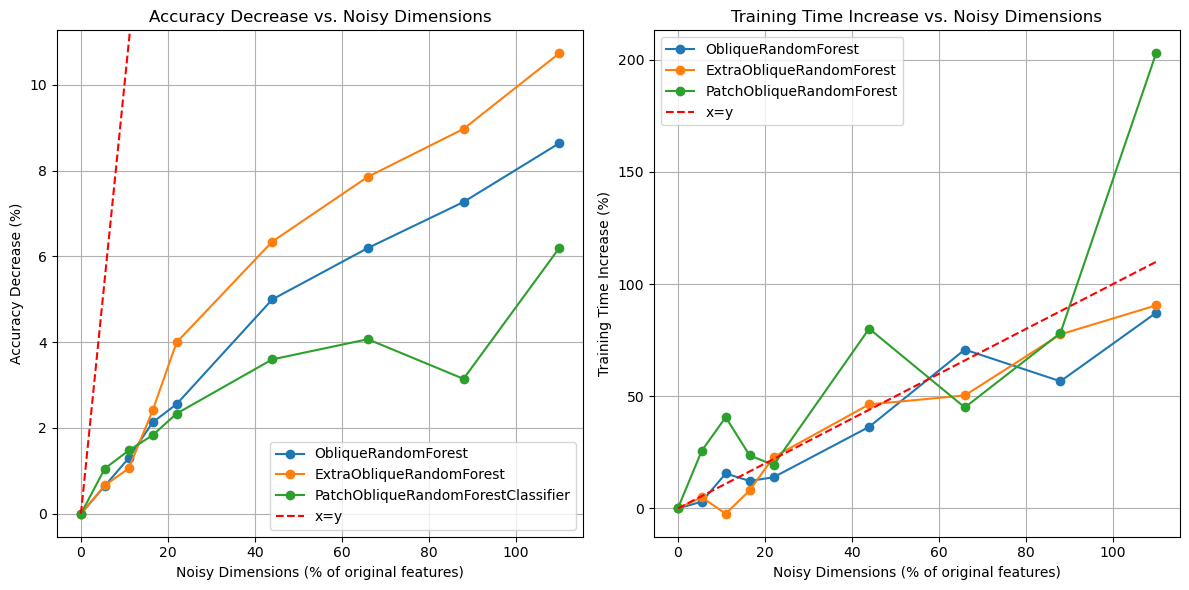

In [63]:

# Load the saved result file.
result_filepath = os.path.join(".", "result", "results.txt")
data = np.loadtxt(result_filepath, delimiter=",", skiprows=1)

# Data columns:
# col0: noise_dim
# col1: ObliqueRandomForest_Accuracy, col2: ObliqueRandomForest_Time,
# col3: ExtraObliqueRandomForest_Accuracy, col4: ExtraObliqueRandomForest_Time,
# col5: PatchObliqueRandomForestClassifier_Accuracy, col6: PatchObliqueRandomForestClassifier_Time

# Get the original number of features.
original_features = X1_human.shape[1]  # Adjust if necessary.

# Compute x-axis: percentage of noisy dimensions relative to the original features.
noise_percent = (data[:, 0] / original_features) * 100

# Extract baseline values (noise_dim = 0, first row) for each classifier.
baseline_orf_acc  = data[0, 1]  # ObliqueRandomForest accuracy
baseline_orf_time = data[0, 2]
baseline_eorf_acc  = data[0, 3]  # ExtraObliqueRandomForest accuracy
baseline_eorf_time = data[0, 4]
baseline_porfc_acc  = data[0, 5]  # PatchObliqueRandomForestClassifier accuracy
baseline_porfc_time = data[0, 6]

# Compute percentage accuracy decrease for each classifier.
orf_acc_decrease   = ((baseline_orf_acc - data[:, 1]) / baseline_orf_acc) * 100
eorf_acc_decrease  = ((baseline_eorf_acc - data[:, 3]) / baseline_eorf_acc) * 100
porfc_acc_decrease = ((baseline_porfc_acc - data[:, 5]) / baseline_porfc_acc) * 100

# Compute percentage training time increase for each classifier.
orf_time_increase   = ((data[:, 2] - baseline_orf_time) / baseline_orf_time) * 100
eorf_time_increase  = ((data[:, 4] - baseline_eorf_time) / baseline_eorf_time) * 100
porfc_time_increase = ((data[:, 6] - baseline_porfc_time) / baseline_porfc_time) * 100

# Create subplots and compute y-axis limits based solely on the data.
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Accuracy Decrease Plot
ax[0].plot(noise_percent, orf_acc_decrease, marker='o', label="ObliqueRandomForest")
ax[0].plot(noise_percent, eorf_acc_decrease, marker='o', label="ExtraObliqueRandomForest")
ax[0].plot(noise_percent, porfc_acc_decrease, marker='o', label="PatchObliqueRandomForestClassifier")

# Compute y-axis limits from data only.
all_acc = np.concatenate([orf_acc_decrease, eorf_acc_decrease, porfc_acc_decrease])
ymin_acc, ymax_acc = np.min(all_acc), np.max(all_acc)
margin_acc = 0.05 * (ymax_acc - ymin_acc) if ymax_acc != ymin_acc else 0.1
ax[0].set_ylim(ymin_acc - margin_acc, ymax_acc + margin_acc)

# Add the red dotted x=y line (it will be clipped if outside the data range).
ax[0].plot(noise_percent, noise_percent, 'r--', label="x=y", clip_on=True)

ax[0].set_xlabel("Noisy Dimensions (% of original features)")
ax[0].set_ylabel("Accuracy Decrease (%)")
ax[0].set_title("Accuracy Decrease vs. Noisy Dimensions")
ax[0].legend()
ax[0].grid(True)

# Training Time Increase Plot
ax[1].plot(noise_percent, orf_time_increase, marker='o', label="ObliqueRandomForest")
ax[1].plot(noise_percent, eorf_time_increase, marker='o', label="ExtraObliqueRandomForest")
ax[1].plot(noise_percent, porfc_time_increase, marker='o', label="PatchObliqueRandomForest")

# Compute y-axis limits from training time data.
all_time = np.concatenate([orf_time_increase, eorf_time_increase, porfc_time_increase])
ymin_time, ymax_time = np.min(all_time), np.max(all_time)
margin_time = 0.05 * (ymax_time - ymin_time) if ymax_time != ymin_time else 0.1
ax[1].set_ylim(ymin_time - margin_time, ymax_time + margin_time)

# Add the red dotted x=y line.
ax[1].plot(noise_percent, noise_percent, 'r--', label="x=y", clip_on=True)

ax[1].set_xlabel("Noisy Dimensions (% of original features)")
ax[1].set_ylabel("Training Time Increase (%)")
ax[1].set_title("Training Time Increase vs. Noisy Dimensions")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


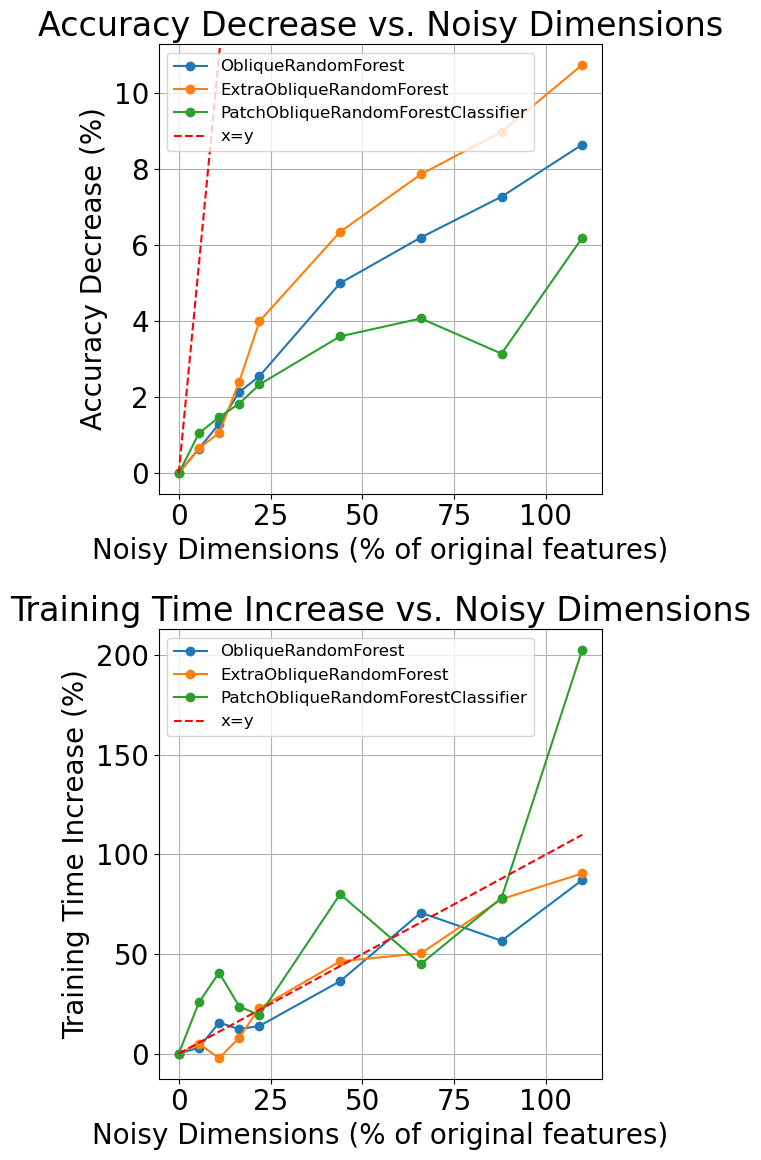

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved result file.
result_filepath = os.path.join(".", "result", "results.txt")
data = np.loadtxt(result_filepath, delimiter=",", skiprows=1)

# Data columns:
# col0: noise_dim
# col1: ObliqueRandomForest_Accuracy, col2: ObliqueRandomForest_Time,
# col3: ExtraObliqueRandomForest_Accuracy, col4: ExtraObliqueRandomForest_Time,
# col5: PatchObliqueRandomForestClassifier_Accuracy, col6: PatchObliqueRandomForestClassifier_Time

# Get the original number of features.
original_features = X1_human.shape[1]  # Adjust if necessary.

# Compute x-axis: percentage of noisy dimensions relative to the original features.
noise_percent = (data[:, 0] / original_features) * 100

# Extract baseline values (noise_dim = 0, first row) for each classifier.
baseline_orf_acc  = data[0, 1]  # ObliqueRandomForest accuracy
baseline_orf_time = data[0, 2]
baseline_eorf_acc  = data[0, 3]  # ExtraObliqueRandomForest accuracy
baseline_eorf_time = data[0, 4]
baseline_porfc_acc  = data[0, 5]  # PatchObliqueRandomForestClassifier accuracy
baseline_porfc_time = data[0, 6]

# Compute percentage accuracy decrease for each classifier.
orf_acc_decrease   = ((baseline_orf_acc - data[:, 1]) / baseline_orf_acc) * 100
eorf_acc_decrease  = ((baseline_eorf_acc - data[:, 3]) / baseline_eorf_acc) * 100
porfc_acc_decrease = ((baseline_porfc_acc - data[:, 5]) / baseline_porfc_acc) * 100

# Compute percentage training time increase for each classifier.
orf_time_increase   = ((data[:, 2] - baseline_orf_time) / baseline_orf_time) * 100
eorf_time_increase  = ((data[:, 4] - baseline_eorf_time) / baseline_eorf_time) * 100
porfc_time_increase = ((data[:, 6] - baseline_porfc_time) / baseline_porfc_time) * 100

fig, ax = plt.subplots(2,1, figsize=(6, 12))

# Accuracy Decrease Plot
ax[0].plot(noise_percent, orf_acc_decrease, marker='o', label="ObliqueRandomForest")
ax[0].plot(noise_percent, eorf_acc_decrease, marker='o', label="ExtraObliqueRandomForest")
ax[0].plot(noise_percent, porfc_acc_decrease, marker='o', label="PatchObliqueRandomForestClassifier")

# Compute y-axis limits from data only.
all_acc = np.concatenate([orf_acc_decrease, eorf_acc_decrease, porfc_acc_decrease])
ymin_acc, ymax_acc = np.min(all_acc), np.max(all_acc)
margin_acc = 0.05 * (ymax_acc - ymin_acc) if ymax_acc != ymin_acc else 0.1
ax[0].set_ylim(ymin_acc - margin_acc, ymax_acc + margin_acc)

# Add red dotted x=y line.
ax[0].plot(noise_percent, noise_percent, 'r--', label="x=y", clip_on=True)

ax[0].set_xlabel("Noisy Dimensions (% of original features)", fontsize=20)
ax[0].set_ylabel("Accuracy Decrease (%)", fontsize=20)
ax[0].set_title("Accuracy Decrease vs. Noisy Dimensions", fontsize=24)
ax[0].legend(fontsize=12)
ax[0].grid(True)

# Training Time Increase Plot
ax[1].plot(noise_percent, orf_time_increase, marker='o', label="ObliqueRandomForest")
ax[1].plot(noise_percent, eorf_time_increase, marker='o', label="ExtraObliqueRandomForest")
ax[1].plot(noise_percent, porfc_time_increase, marker='o', label="PatchObliqueRandomForestClassifier")

# Compute y-axis limits from training time data.
all_time = np.concatenate([orf_time_increase, eorf_time_increase, porfc_time_increase])
ymin_time, ymax_time = np.min(all_time), np.max(all_time)
margin_time = 0.05 * (ymax_time - ymin_time) if ymax_time != ymin_time else 0.1
ax[1].set_ylim(ymin_time - margin_time, ymax_time + margin_time)

# Add red dotted x=y line.
ax[1].plot(noise_percent, noise_percent, 'r--', label="x=y", clip_on=True)

ax[1].set_xlabel("Noisy Dimensions (% of original features)", fontsize=20)
ax[1].set_ylabel("Training Time Increase (%)", fontsize=20)
ax[1].set_title("Training Time Increase vs. Noisy Dimensions", fontsize=24)
ax[1].legend(fontsize=12)
ax[1].grid(True)

plt.tight_layout()
plt.show()


# Implement preliminary GPU forest

In [48]:
x_gpu = cp.array([1, 2, 3])
x_gpu

array([1, 2, 3])

In [ ]:


# Get properties of device 0 (adjust if you have multiple GPUs)
props = cp.cuda.runtime.getDeviceProperties(0)
print("GPU Properties:", props)
major = props['major']
minor = props['minor']
print(f"Compute capability: compute_{major}{minor}")


GPU Properties: {'name': b'NVIDIA GeForce RTX 5080', 'totalGlobalMem': 17094475776, 'sharedMemPerBlock': 49152, 'regsPerBlock': 65536, 'warpSize': 32, 'maxThreadsPerBlock': 1024, 'maxThreadsDim': (1024, 1024, 64), 'maxGridSize': (2147483647, 65535, 65535), 'clockRate': 2700000, 'totalConstMem': 65536, 'major': 12, 'minor': 0, 'textureAlignment': 512, 'texturePitchAlignment': 32, 'multiProcessorCount': 84, 'kernelExecTimeoutEnabled': 1, 'integrated': 0, 'canMapHostMemory': 1, 'computeMode': 0, 'maxTexture1D': 131072, 'maxTexture2D': (131072, 65536), 'maxTexture3D': (16384, 16384, 16384), 'concurrentKernels': 1, 'ECCEnabled': 0, 'pciBusID': 1, 'pciDeviceID': 0, 'pciDomainID': 0, 'tccDriver': 0, 'memoryClockRate': 15001000, 'memoryBusWidth': 256, 'l2CacheSize': 67108864, 'maxThreadsPerMultiProcessor': 1536, 'isMultiGpuBoard': 0, 'cooperativeLaunch': 1, 'cooperativeMultiDeviceLaunch': 0, 'deviceOverlap': 1, 'maxTexture1DMipmap': 32768, 'maxTexture1DLinear': 268435456, 'maxTexture1DLayered'

In [44]:
os.environ["CUPY_NVRTC_FLAGS"] = f"--gpu-architecture=compute_{major}{minor}"

In [49]:
os.environ["CUPY_NVRTC_FLAGS"] = ""


In [51]:
gpu_rf = GPUObliqueRandomForest(n_estimators=5, max_depth=5, min_samples_leaf=10, n_candidates=20)

# Measure training time.
start_train = time.time()
gpu_rf.fit(X_human, y_human)
train_time = time.time() - start_train

# Measure prediction time.
start_test = time.time()
predictions = gpu_rf.predict(X_human)
test_time = time.time() - start_test

# Compute accuracy (assuming y_human is a NumPy array).
accuracy = np.mean(predictions == y_human)

print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {test_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")

CompileException: nvrtc: error: invalid value for --gpu-architecture (-arch)


In [52]:
import cupy as cp
props = cp.cuda.runtime.getDeviceProperties(0)
major = props['major']
minor = props['minor']
print(f"Detected GPU Compute Capability: compute_{major}{minor}")


Detected GPU Compute Capability: compute_120
